In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
# %%
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights, vit_b_16, ViT_B_16_Weights

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
# Load Excel files
control_df = pd.read_excel('Control_Iris.xlsx')  
diabetes_df = pd.read_excel('Diabetic_Iris.xlsx')  

# Preview the data
print("Control Data Sample:")
print(control_df.head())

print("\nDiabetes Data Sample:")
print(diabetes_df.head())


Control Data Sample:
  ID   Age Gender Eye
0  1  65.0      F   L
1  2  28.0      M   B
2  3  53.0      ?   L
3  4  73.0      M   L
4  5  45.0      M   R

Diabetes Data Sample:
  ID   Age Gender  DiabeteType Eye ControllingManner  DRtype
0  1  69.0      F          2.0   B                 W     0.0
1  2  72.0      F          2.0   R                 W     0.0
2  3  51.0      F          2.0   B                 P     1.0
3  4  75.0      F          2.0   R                 P     1.0
4  5  60.0      F          2.0   R                 W     0.0


In [18]:
import glob

control_images = glob.glob('Control2/**/*.jpg', recursive=True)
diabetes_images = glob.glob('Diabetes2/**/*.jpg', recursive=True)

print("Control image example paths:")
print(control_images[:5])

print("Diabetes image example paths:")
print(diabetes_images[:5])


Control image example paths:
['Control2\\1\\IMG_2016_10_26_9999_20.JPG', 'Control2\\1\\ans\\IMG_2016_10_26_9999_20.JPGans.jpg', 'Control2\\10\\IMG_2016_10_26_9999_248.JPG', 'Control2\\10\\IMG_2016_10_26_9999_257.JPG', 'Control2\\10\\ans\\IMG_2016_10_26_9999_248.JPGans.jpg']
Diabetes image example paths:
['Diabetes2\\1\\IMG_2016_11_02_9999_334.JPG', 'Diabetes2\\1\\IMG_2016_11_02_9999_335.JPG', 'Diabetes2\\1\\ans\\IMG_2016_11_02_9999_334.JPGans.jpg', 'Diabetes2\\1\\ans\\IMG_2016_11_02_9999_335.JPGans.jpg', 'Diabetes2\\10\\IMG_2016_06_25_9999_226.JPG']


In [19]:
# Add labels
control_df['Label'] = 0
diabetes_df['Label'] = 1

# Ensure ID is string
control_df['ID'] = control_df['ID'].astype(str)
diabetes_df['ID'] = diabetes_df['ID'].astype(str)

# Function to get image from subfolder
def find_image_path(base_folder, id_value):
    folder_path = os.path.join(base_folder, id_value)
    images = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.JPG"))
    if images:
        return images[0]  # Return the first image found
    return None

# Map images
control_df['ImagePath'] = control_df['ID'].apply(lambda x: find_image_path('Control2', x))
diabetes_df['ImagePath'] = diabetes_df['ID'].apply(lambda x: find_image_path('Diabetes2', x))

# Combine and drop rows where images were not found
full_df = pd.concat([control_df, diabetes_df], ignore_index=True)
full_df = full_df.dropna(subset=['ImagePath'])

print(full_df.head())
print("Total valid images found:", len(full_df))

  ID   Age Gender Eye  Label                               ImagePath  \
0  1  65.0      F   L      0   Control2\1\IMG_2016_10_26_9999_20.JPG   
1  2  28.0      M   B      0  Control2\2\IMG_2016_10_26_9999_150.JPG   
2  3  53.0      ?   L      0  Control2\3\IMG_2016_10_26_9999_159.JPG   
3  4  73.0      M   L      0  Control2\4\IMG_2016_10_26_9999_196.JPG   
4  5  45.0      M   R      0  Control2\5\IMG_2016_10_26_9999_218.JPG   

   DiabeteType ControllingManner  DRtype  
0          NaN               NaN     NaN  
1          NaN               NaN     NaN  
2          NaN               NaN     NaN  
3          NaN               NaN     NaN  
4          NaN               NaN     NaN  
Total valid images found: 192


In [20]:
# Balance the dataset to 1000 samples per class
from sklearn.utils import resample

# Separate by class
control_class = full_df[full_df['Label'] == 0]
diabetes_class = full_df[full_df['Label'] == 1]

# Resample both to 1000 each (oversample if needed, otherwise undersample)
control_balanced = resample(control_class,
                            replace=True,      # allow resampling with replacement
                            n_samples=1000,
                            random_state=42)

diabetes_balanced = resample(diabetes_class,
                             replace=True,
                             n_samples=1000,
                             random_state=42)

# Combine the balanced data
balanced_df = pd.concat([control_balanced, diabetes_balanced]).sample(frac=1, random_state=42).reset_index(drop=True)

# Replace full_df with balanced version
full_df = balanced_df

# Check result
print(full_df['Label'].value_counts())


Label
1    1000
0    1000
Name: count, dtype: int64


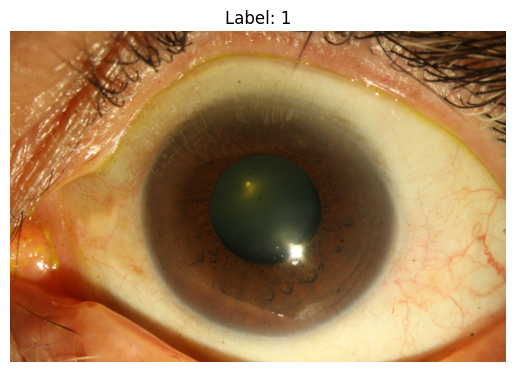

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

sample_path = full_df.iloc[0]['ImagePath']
img = Image.open(sample_path)

plt.imshow(img)
plt.title(f"Label: {full_df.iloc[0]['Label']}")
plt.axis('off')
plt.show()


In [22]:

class IrisDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['ImagePath']
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['Label'])
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Train/Test Split
train_df, test_df = train_test_split(full_df, test_size=0.2, stratify=full_df['Label'], random_state=42)
train_dataset = IrisDataset(train_df, transform=transform)
test_dataset = IrisDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
# Train ResNet18
resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model = resnet_model.to(device)

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)

for epoch in range(10):
    resnet_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = resnet_model(images)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        total_loss += loss.item()
    print(f"[ResNet18] Epoch {epoch+1}, Loss: {total_loss:.4f}")

[ResNet18] Epoch 1, Loss: 4.8774
[ResNet18] Epoch 2, Loss: 0.1158
[ResNet18] Epoch 3, Loss: 0.0276
[ResNet18] Epoch 4, Loss: 0.0216
[ResNet18] Epoch 5, Loss: 0.0129
[ResNet18] Epoch 6, Loss: 0.0155
[ResNet18] Epoch 7, Loss: 0.0088
[ResNet18] Epoch 8, Loss: 0.0082
[ResNet18] Epoch 9, Loss: 0.0053
[ResNet18] Epoch 10, Loss: 0.0061


In [24]:
# Train ViT
vit_model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 2)
vit_model = vit_model.to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

for epoch in range(10):
    vit_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_vit.zero_grad()
        outputs = vit_model(images)
        loss = criterion_vit(outputs, labels)
        loss.backward()
        optimizer_vit.step()
        total_loss += loss.item()
    print(f"[ViT] Epoch {epoch+1}, Loss: {total_loss:.4f}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\GALAXY/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100%|██████████| 330M/330M [06:40<00:00, 864kB/s]  


[ViT] Epoch 1, Loss: 28.8096
[ViT] Epoch 2, Loss: 2.1090
[ViT] Epoch 3, Loss: 1.5129
[ViT] Epoch 4, Loss: 0.0099
[ViT] Epoch 5, Loss: 0.0069
[ViT] Epoch 6, Loss: 0.0053
[ViT] Epoch 7, Loss: 0.0042
[ViT] Epoch 8, Loss: 0.0035
[ViT] Epoch 9, Loss: 0.0030
[ViT] Epoch 10, Loss: 0.0026


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [26]:
def evaluate_model(model, dataloader, model_name="Model"):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            if isinstance(outputs, tuple):  # In case the model has multiple heads
                outputs = outputs[0]

            preds = torch.argmax(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class 1

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    FAR = fp / (fp + tn + 1e-6)
    FRR = fn / (fn + tp + 1e-6)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n🔍 Evaluation for {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"False Acceptance Rate (FAR): {FAR:.4f}")
    print(f"False Rejection Rate (FRR): {FRR:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()



🔍 Evaluation for ResNet18
Accuracy: 1.0000
False Acceptance Rate (FAR): 0.0000
False Rejection Rate (FRR): 0.0000

Confusion Matrix:
[[200   0]
 [  0 200]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



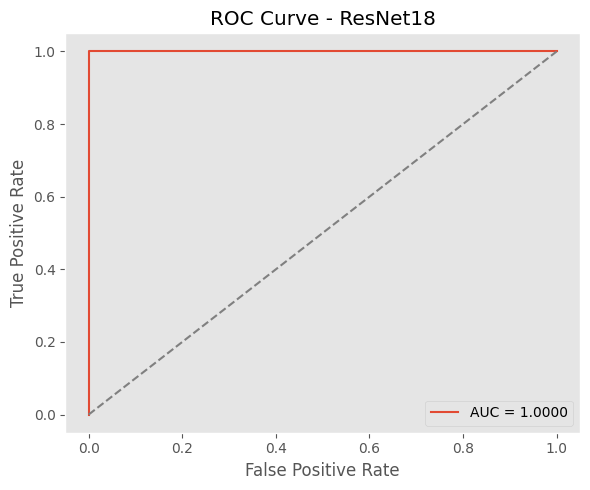


🔍 Evaluation for ViT
Accuracy: 1.0000
False Acceptance Rate (FAR): 0.0000
False Rejection Rate (FRR): 0.0000

Confusion Matrix:
[[200   0]
 [  0 200]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



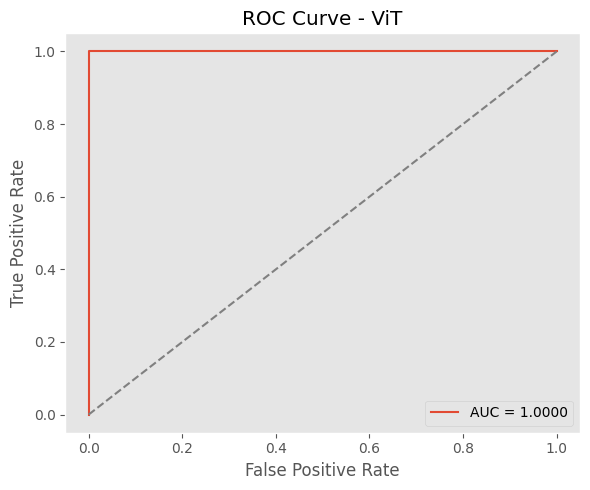

In [27]:
evaluate_model(resnet_model, test_loader, model_name="ResNet18")
evaluate_model(vit_model, test_loader, model_name="ViT")
